# Overview
pytorchによるCNNの実装を行う
0. seed値の固定
1. dataset, dataloader classの作成
2. modelの定義
3. loss関数、optimizerの定義
4. trainingとvalidation
5. test dataによる性能評価

扱わないこと  
K分割交差検証、GPUの利用方法、callbackの利用方法、分類問題の解き方

# 0. seed値の固定
乱数値を固定する。  
再現性が取れなくなるので絶対にやりましょう

In [1]:
import random
import numpy as np
import os
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # type: ignore
set_seed()

# 1. dataset,dataloader classの作成
学習させるデータをdataset class,  
データをバッチ毎にloadする存在をdataloader classとして定義する。  
詳しくは以下のサイト参照  
https://ohke.hateblo.jp/entry/2019/12/28/230000

dataは、画像データ群と、画像データのファイル名等のメタ情報をまとめたdataframeの組み合わせとして用意するのが一般的。  
まずはdataframeからデータを理解する

In [2]:
import pandas as pd

train_data_dir = 'inputs/MNIST_small/train'
df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))
print(len(df))
df.head()


180


,x,y
0,img_13831.jpg,0
1,img_14186.jpg,0
2,img_30030.jpg,0
3,img_21129.jpg,0
4,img_37993.jpg,0


trainとvalidationに分割

In [3]:
import sklearn.model_selection as sms
train_df,valid_df = sms.train_test_split(df,test_size = 0.2,stratify=df['y'],random_state=42)
print(f'num data train: {len(train_df)}')
print(f'num data train: {len(valid_df)}')
valid_df.head()

num data train: 144
num data train: 36


,x,y
143,img_5811.jpg,2
174,img_32182.jpg,5
24,img_34524.jpg,7
60,img_30756.jpg,1
157,img_22408.jpg,2


In [4]:
test_data_dir = 'inputs/MNIST_small/test'
test_df = pd.read_csv(os.path.join(test_data_dir,'test.csv'))
print(len(test_df))
test_df.head()

45


,x,y
0,img_14179.jpg,0
1,img_41636.jpg,0
2,img_17470.jpg,0
3,img_8460.jpg,0
4,img_3253.jpg,0


画像の読み込みをしてみる

L
(28, 28)


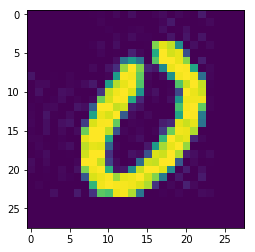

In [5]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(os.path.join(test_data_dir,test_df['x'].values[0]))
print(img.mode)
print(img.size)
plt.imshow(img)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('L')),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])


class OriginalDataset(Dataset):
    def __init__(self, data_dir, df,tranform):
        self.data_dir = data_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        image_file_name = self.df['x'].values[idx]
        x = Image.open(os.path.join(self.data_dir, image_file_name))
        x = self.transform(x)

        y = self.df['y'].values[idx]

        return x.float(), torch.tensor(y).float()

train_dataset = OriginalDataset(train_data_dir,train_df,transform)
valid_dataset = OriginalDataset(train_data_dir,valid_df,transform)
test_dataset = OriginalDataset(test_data_dir,test_df,transform)


In [7]:
print(train_dataset[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0275, 0.0000, 0.0000, 0.0235, 0.0000, 0.0000,
          0.0235, 0.0000, 0.0000, 0.0000, 0.0275, 0.0196, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0118, 0.0039, 0.0275, 0.0000, 0.0000, 0.0000, 0.0078, 0.0078,
          0.0000, 0.0118, 0.0235, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0235, 0.0000, 0.0392, 0.0000, 0.0392, 0.0000,
          0.0000, 0.0118, 0.0118, 0.0000, 0.0000, 0.0118, 0.0314, 0.0431,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0039, 0.0000, 0.0000, 0.0196, 0.0000, 0.0039, 0.0000,
          0.0275, 0.0000, 0.0000, 0.0118, 0.0157, 0.0078

In [8]:
train_loader = DataLoader(train_dataset,batch_size = 4,shuffle = True)
valid_loader = DataLoader(train_dataset,batch_size = 4,shuffle = False)
test_loader =DataLoader(train_dataset,batch_size = 4,shuffle = False)


Labels:  [6. 5. 4. 1.]


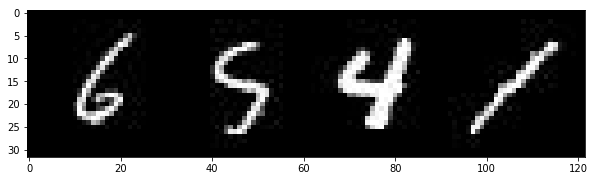

In [9]:
from torchvision.utils import make_grid
import numpy as np
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:4].numpy())

# Print the first 12 images
im = make_grid(images[:4], nrow=4)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# 2. model定義
簡単なconvolution networkから

In [10]:
import torch.nn as nn

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(conv1.out_channels, 16, 3, 1)

In [11]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_dataset):
    break

In [12]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [13]:
import torch.nn.functional as F
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [14]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [15]:

# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [16]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [17]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


In [18]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(self.conv1.out_channels, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze(1)

In [19]:
model = ConvNet()
model

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [20]:
x = X_train.view(1,1,28,28)
output = model(x)
print(output)

tensor([-0.0491], grad_fn=<SqueezeBackward1>)


# 3.loss関数、optimizerの定義
loss関数...cost関数とも呼ばれ、modelの予測結果を評価する関数。  
modelの学習の振る舞いを決定するため、かなり重要。  
目的に応じてloss関数はカスタマイズ出来る。例えば、ある特定の間違いをした場合のみ、lossを高く評価する等、、、  
今回は、簡単のためRMSEで定義（本来はクラス分類タスクなので、cross entropy loss等が望ましい）。

optimizer...誤差逆伝播により得られた各パラメータの勾配情報をもとに、パラメータをアップデート

In [21]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, input, target):
        return torch.sqrt(self.mse(input, target))
    
loss_func = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4.学習とvalidation

In [29]:

epochs = 50
train_losses = []
valid_losses = []

for i in range(epochs):
    train_loss = 0
    valid_loss = 0
    valid_pred = []
    valid_true = []

    
    for X_train, y_train in train_loader:
    
        y_pred = model(X_train)  # we don't flatten X-train here
        batch_loss = loss_func(y_pred, y_train)
 
        
        # Update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()
        
    train_loss /= len(train_loader)
        
    train_losses.append(train_loss)
        

    for X_val, y_val in valid_loader:
        with torch.no_grad():
            y_pred = model(X_val)
        valid_pred.append(y_pred)
        valid_true.append(y_val)
            
        batch_loss = loss_func(y_pred, y_val)
        valid_loss += batch_loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
                        
    
    print(f'epoch: {i:2}   train_loss: {train_loss:10.8f}  valid_loss: {valid_loss:10.8f}  ')
    print(f'valid_pred : {valid_pred[0]} valid_true {valid_true[0]}')
    print('-----------------------------')

epoch:  0   train_loss: 0.16811991  valid_loss: 0.12704711  
valid_pred : tensor([-0.0969,  3.9688,  0.0199,  1.9593]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch:  1   train_loss: 0.12429119  valid_loss: 0.10642490  
valid_pred : tensor([-0.1303,  4.1543, -0.1139,  1.9200]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch:  2   train_loss: 0.13390476  valid_loss: 0.12604957  
valid_pred : tensor([0.0250, 4.0698, 0.0385, 1.9520]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch:  3   train_loss: 0.17241146  valid_loss: 0.12492191  
valid_pred : tensor([-0.0232,  4.2205, -0.0279,  2.0072]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch:  4   train_loss: 0.18534913  valid_loss: 0.12054262  
valid_pred : tensor([-0.0171,  3.9627, -0.0243,  1.9995]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch:  5   train_loss: 0.17088357  valid_loss: 0.23090416  
valid_pred : tenso

epoch: 45   train_loss: 0.18038178  valid_loss: 0.12083614  
valid_pred : tensor([0.0196, 3.9270, 0.0589, 2.0125]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch: 46   train_loss: 0.16854836  valid_loss: 0.14067454  
valid_pred : tensor([0.0365, 4.1278, 0.0523, 2.0196]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch: 47   train_loss: 0.16996771  valid_loss: 0.17228819  
valid_pred : tensor([-0.0953,  3.9241, -0.0906,  1.8779]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch: 48   train_loss: 0.14445656  valid_loss: 0.13373481  
valid_pred : tensor([0.0272, 4.1108, 0.0763, 2.1082]) valid_true tensor([0., 4., 0., 2.])
-----------------------------
epoch: 49   train_loss: 0.11081313  valid_loss: 0.10961472  
valid_pred : tensor([0.0070, 4.0678, 0.0606, 2.0044]) valid_true tensor([0., 4., 0., 2.])
-----------------------------


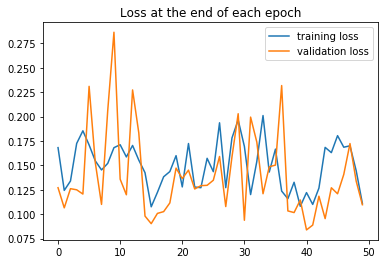

In [30]:
plt.plot(train_losses, label='training loss')
plt.plot(valid_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

# 5. test dataによる性能評価

In [31]:
test_loss=0
for X_test,y_test in test_loader:
    with torch.no_grad():
            y_pred = model(X_test)
            
    batch_loss = loss_func(y_pred, y_test)
    test_loss += batch_loss.item()

test_loss /= len(test_loader)
print(f'test loss : {test_loss:.4f}')


test loss : 0.1096
